# Машинное обучение, ФКН ВШЭ
## Практическое задание 3.

Задание состоит из трех независимых разделов, посвященных bias-variance decomposition, решающим деревьям и композициям алгоритмов. Эти разделы можно выполнять в любом порядке. В каждом разделе вам предложена одна или две задачи, которые, в свою очередь, делятся на пункты. Баллы даются за выполнение пунктов, причем в рамках одной задачи пункты, как правило, зависимы (нельзя решить следующий, не решив предыдущего). Пункты могут быть двух видов: написать скрипт или ответить на вопросы. Задачи в рамках одного раздела рекомендуется решать в том порядке, в котором они даны в задании. В разных задачах используются разные наборы данных, все наборы взяты из репозитория UCI. 

Задание направлено на более глубокое ознакомление с тем, как работают решающие деревья, случайные леса и как устроено разложение на смещение и разброс. Кроме того, задание предполагает проведение экспериментов и анализ их результатов (мини-исследования). 

### Формат сдачи
Для сдачи задания переименуйте получившийся файл \*.ipynb в соответствии со следующим форматом: *HW1_Username.ipynb*, где *Username* — Ваша фамилия и инициалы на латинице (например, *HW1_IvanovII.ipynb*). Далее отправьте этот файл на Smorodinov-1990@mail.ru.

### I. Разложение ошибки на смещение и разброс
#### Теоретическое вступление
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar x} f(\bar x)$ функции от многомерной случайной величины $\bar x = (x_1, \dots, x_d)$, $\bar x \sim p(\bar x)$, можно сгенерировать выборку из распределения $p(\bar x)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar x} f(x) = \int f(\bar x) p(\bar x) d \bar x \approx \frac 1 m \sum_{i=1}^m f(\bar x_i), \, \bar x_i \sim p(\bar x), i = 1, \dots, m.$$

Для оценки многомерных интегралов ($d > 1$) объекты лучше генерировать, следуя специальным схемам, чтобы адекватно оценивать значение интеграла в областях высокой плотности. Мы не будем так усложнять задачу, а просто будем генерировать $\bar x_i$ независимо.

In [1]:
import numpy as np

Например, оценим $\mathbb{E}_x x^2,$ $x \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_x x^2 = \sigma^2 + \mu^2 = 34$):

In [2]:
x = np.random.normal(loc=5, scale=3, size=1000)
(x**2).mean()

np.float64(33.75845050119456)

Или посчитаем многомерный интеграл $\mathbb{E}_{\bar x} \bar x^T \bar x = \mathbb{E}_{\bar x} \sum_{i=1}^d x_i^2$, $\bar x \sim \mathcal{N}(\bar \mu=(1, \dots, 1), \Sigma=I)$ при $d = 10$ (аналитический ответ 20):

In [3]:
d = 10
X = np.random.multivariate_normal(np.ones(10), np.eye(10), size=1000)
(X**2).sum(axis=1).mean()

np.float64(20.203126946251118)

Чтобы оценить интеграл по выборке, можно сгенерировать несколько выборок, вычислить на них значение функции и усреднить. Например, для интеграла $\mathbb{E}_X [\mu(X)(x)]$ генерируются выборки $X_1, \dots, X_m$, на каждой из них обучается алгоритм $\mu$ и делается предсказание для объекта $x$.

#### Практическая часть
##### Задача 1. Построение "среднего" алгоритма $\mathbb{E}_X [\mu(X)]$
В этом задании вам нужно построить графики, демонстрирующие, как алгоритм $\mathbb{E}_X [\mu(X)]$ аппроксимирует истинную зависимость в данных и как он меняется в зависимости от гиперпараметров метода обучения.

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
def f(x):
    return np.sin(x)   # истинная зависимость в данных
sample_size = 100      # длина выборки
samples_num = 20       # количество выборок
linspace = np.linspace(0, 7, 1000)  # точки для построения графиков

__1 (0.3 балла)__
1. Сгенерируйте выборку x из одномерного экспоненциального распределения (np.random.exponential) длины sample_size.
1. Создайте вектор целевых переменных y как сумму f(x) и случайного шума, сгенерированного из равномерного распределения на отрезке [-1, 1] (np.random.uniform).
1. Обучите DecisionTreeRegressor с параметрами по умолчанию на полученной выборке и сделайте предсказания для объектов из linspace.
1. Постройте два графика на одном рисунке: f(x) и зависимость, восстановленную решающим деревом.

    Рекомендация: не забудьте, что все методы обучения в sklearn требуют на вход двумерную матрицу объекты-признаки. Сделать такую из одномерного вектора можно добавлением мнимых осей (np.newaxis).

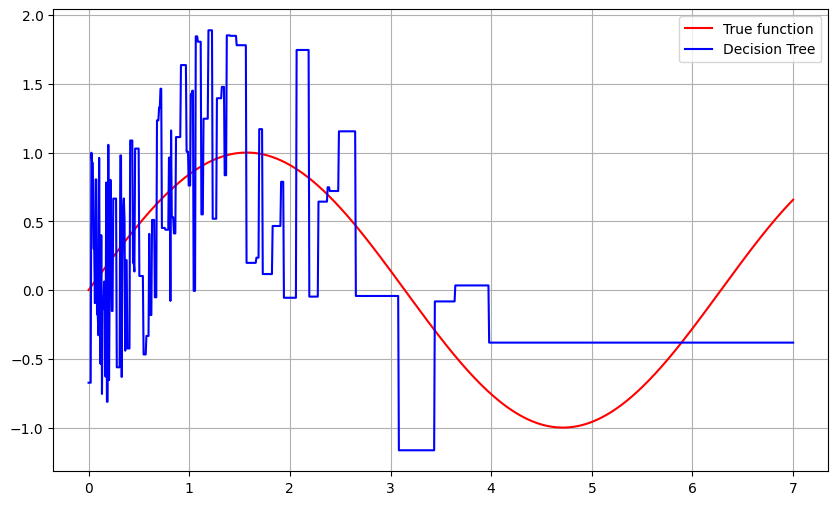

In [6]:
from sklearn.tree import DecisionTreeRegressor
import numpy as np
from matplotlib import pyplot as plt

# 1. Генерируем выборку из экспоненциального распределения
x = np.random.exponential(scale=1, size=100)

# 2. Создаем целевые переменные с шумом
y = f(x) + np.random.uniform(low=-1, high=1, size=100)

# 3. Обучаем дерево
X = x[:, np.newaxis]  # преобразуем в двумерный массив
dt = DecisionTreeRegressor()
dt.fit(X, y)
predictions = dt.predict(linspace[:, np.newaxis])

# 4. Строим графики
plt.figure(figsize=(10, 6))
plt.plot(linspace, f(linspace), label='True function', color='red')
plt.plot(linspace, predictions, label='Decision Tree', color='blue')
plt.legend()
plt.grid(True)
plt.show()

__2 (0.3 балла):__

Повторите первые 3 шага, описанные выше, samples_num раз. На одном графике для каждого обученного решающего дерева визуализируйте восстановленную им зависимость (рекомендуется все такие линии рисовать полупрозрачными и серым цветом: plt.plot(...... color="gray", alpha=0.5)).  На этом же графике изобразите истинную зависимость f(x) (красным цветом: color="red") и усредненную по всем деревьям восстановленную зависимость (черным цветом: color="black").    

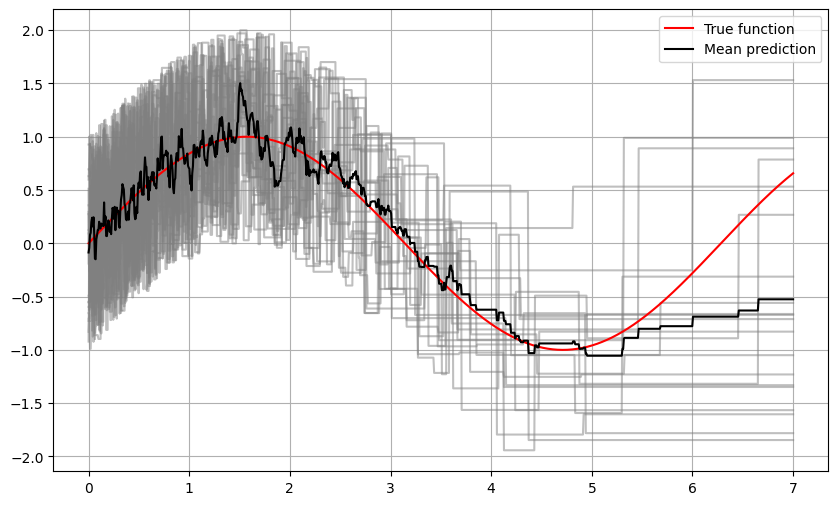

In [7]:
plt.figure(figsize=(10, 6))

predictions_all = []

# Повторяем 20 раз
for _ in range(samples_num):
    x = np.random.exponential(scale=1, size=sample_size)
    y = f(x) + np.random.uniform(low=-1, high=1, size=sample_size)
    X = x[:, np.newaxis]
    
    dt = DecisionTreeRegressor()
    dt.fit(X, y)
    pred = dt.predict(linspace[:, np.newaxis])
    predictions_all.append(pred)
    
    plt.plot(linspace, pred, color='gray', alpha=0.5)

predictions_mean = np.mean(predictions_all, axis=0)

plt.plot(linspace, f(linspace), label='True function', color='red')
plt.plot(linspace, predictions_mean, label='Mean prediction', color='black')
plt.legend()
plt.grid(True)
plt.show()

__3 (0.1 балла):__
Повторите предыдущий пункт, установив максимальную глубину решающего дерева равной 2, а затем равной 4. Таким образом, у вас получится еще два графика.

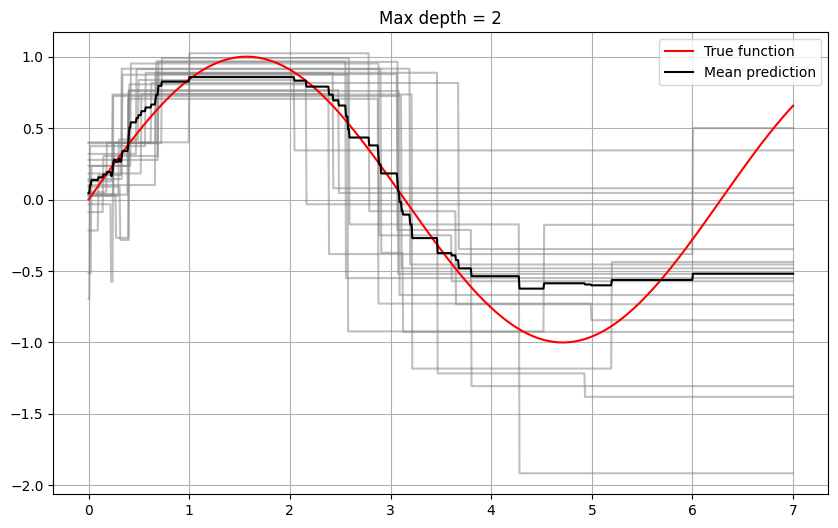

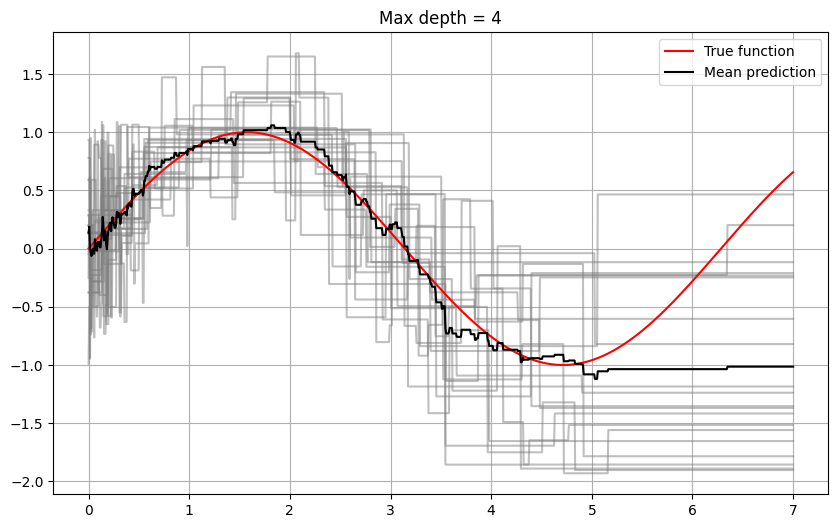

In [8]:
# Для max_depth=2
plt.figure(figsize=(10, 6))
predictions_all = []

for _ in range(samples_num):
    x = np.random.exponential(scale=1, size=sample_size)
    y = f(x) + np.random.uniform(low=-1, high=1, size=sample_size)
    X = x[:, np.newaxis]
    
    dt = DecisionTreeRegressor(max_depth=2)
    dt.fit(X, y)
    pred = dt.predict(linspace[:, np.newaxis])
    predictions_all.append(pred)
    
    plt.plot(linspace, pred, color='gray', alpha=0.5)

predictions_mean = np.mean(predictions_all, axis=0)
plt.plot(linspace, f(linspace), label='True function', color='red')
plt.plot(linspace, predictions_mean, label='Mean prediction', color='black')
plt.title('Max depth = 2')
plt.legend()
plt.grid(True)
plt.show()

# Для max_depth=4
plt.figure(figsize=(10, 6))
predictions_all = []

for _ in range(samples_num):
    x = np.random.exponential(scale=1, size=sample_size)
    y = f(x) + np.random.uniform(low=-1, high=1, size=sample_size)
    X = x[:, np.newaxis]
    
    dt = DecisionTreeRegressor(max_depth=4)
    dt.fit(X, y)
    pred = dt.predict(linspace[:, np.newaxis])
    predictions_all.append(pred)
    
    plt.plot(linspace, pred, color='gray', alpha=0.5)

predictions_mean = np.mean(predictions_all, axis=0)
plt.plot(linspace, f(linspace), label='True function', color='red')
plt.plot(linspace, predictions_mean, label='Mean prediction', color='black')
plt.title('Max depth = 4')
plt.legend()
plt.grid(True)
plt.show()

__4 (0.3 балла)__ Что можно сказать о смещении решающих деревьев, исходя из проведенного эксперимента? В каких из трех рассмотренных случаев (без ограничения на глубину дерева и с ограничением 2 и 4) можно утверждать, что смещение решающего дерева близко к нулю?

(・・ ) ?
Смещение (bias) определяется как разница между истинной функцией и средним предсказанием алгоритма (черная линия). Из графиков видно:

    Без ограничения глубины: среднее предсказание довольно точно следует за истинной функцией → смещение близко к нулю.
    max_depth=2: среднее предсказание сильно упрощено и не улавливает форму sin(x) → большое смещение.
    max_depth=4: среднее предсказание ближе к истинной функции, чем при depth=2, но все еще есть отклонения → смещение меньше, чем при depth=2, но не нулевое.

Вывод: Смещение близко к нулю только в случае без ограничения глубины, так как дерево может полностью подстроиться под данные.



#### Задача 2. Приближенное оценивание смещения и разброса
Реализуем стохастическую процедуру оценивания смещения и разброса алгоритма.

Будем считать, что каждый объект представлен одним признаком, сгенерированным из некоторого распределения, а значение целевой переменной на этом объекте - это сумма значения истинной функции на объекте плюс шумовая компонента, также сгенерированная из некоторого распределения.

__4 (1 балл) __Реализуйте функцию:

In [9]:
def compute_bias_variance(regressor, dependence_fun, x_generator=np.random.uniform, 
                         noise_generator=np.random.uniform, sample_size=100, 
                         samples_num=100, objects_num=50):
    # Генерируем объекты для оценки по x
    x = x_generator(size=objects_num)
    X = x[:, np.newaxis]
    
    # Истинные ответы и шум
    true_y = dependence_fun(x)
    noise = noise_generator(size=objects_num)
    y = true_y + noise
    
    # Оцениваем E[y|x]
    noise_samples = noise_generator(size=objects_num)
    Ey_x = true_y + np.mean(noise_samples)
    
    # Оцениваем E_X[mu(X)]
    predictions = []
    for _ in range(samples_num):
        train_x = x_generator(size=sample_size)
        train_y = dependence_fun(train_x) + noise_generator(size=sample_size)
        regressor.fit(train_x[:, np.newaxis], train_y)
        pred = regressor.predict(X)
        predictions.append(pred)
    
    mean_pred = np.mean(predictions, axis=0)
    
    # Смещение
    bias = np.mean((Ey_x - mean_pred) ** 2)
    
    # Разброс
    variance = np.mean([np.mean((pred - mean_pred) ** 2) for pred in predictions])
    
    return bias, variance

Параметры:
* regressor: объект sklearn-класса, реализующего регрессионный алгоритм (например, DecisionTreeRegressor, LinearRegression, Lasso, RandomForestRegressor ...)
* dependence_fun: функция, задающая истинную зависимость в данных. Принимает на вход вектор и возвращает вектор такой же длины. Примеры: np.sin, lambda x: x\*\*2.
* x_generator: функция, генерирующая одномерную выборку объектов и имеющая параметр size (число объектов в выборке). По умолчанию np.random.uniform.
* noise_generator: функция, генерирующая одномерную выборку шумовых компонент (по одной на каждый объект) и имеющая параметр size (число объектов в выборке). По умолчанию np.random.uniform.
* sample_size: число объектов в выборке.
* samples_num: число выборок, которые нужно сгенерировать, чтобы оценить интеграл по X
* objects_num: число объектов, которые нужно сгенерировать, чтобы оценить интеграл по x.

Вовращаемые значения:
* Смещение алгоритма regressor (число)
* Разброс алгоритма regressor (число)

_Рекомендации:_ 
* Создайте вектор объектов для оценивания интеграла по $x$, затем вектор правильных ответов на нем и вектор зашумленных правильных ответов. $\mathbb{E}[y|x]$ оценивается как сумма правильного ответа на объекте и мат. ожидания шума (который оценивается генерацией отдельной шумовой выборки длины objects_num и усреднением значений в ней). $\mathbb{E}_X [\mu(X)]$ оценивается как в предыдущей задаче: нужно обучить regressor на samples_num выборках длины sample_size и усреднить предсказания на сгенерированных ранее объектах. Смещение - это среднее квадрата разности вектора зашумленных ответов и вектора предсказаний. Для оценки разброса нужно еще раз сгенерировать samples_num выборок.
* Проверить правильность реализации можно на примерах, которые разбирались на семинаре и в домашней работе.

__5 (0.4 балла) Заполните таблицу.__ 

Пусть истинная зависимость данных задается функцией $5\sin (10 x)$, а значения признаков и шум генерируются из одного и того же распределения. Будем пробовать 4 разных распределения и сравнивать 4 регрессионных алгоритма (см. таблицы ниже). Необходимо в каждую ячейку датафреймов bias и variance записать записать соответственно смещение и разброс, рассчитанные для алгоритма, задаваемого строкой таблицы, и генератора случайных чисел, задаваемого столбцом. Остальные параметры функции compute_bias_variance оставьте по умолчанию.

In [10]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [11]:
regressors = [LinearRegression(), 
              DecisionTreeRegressor(), 
              RandomForestRegressor(),
              GradientBoostingRegressor()]
generators = [lambda size: np.random.normal(0, 0.3, size=size), 
              lambda size: np.random.exponential(0.3, size=size), 
              lambda size: np.random.uniform(-1, 1, size=size),
              np.random.uniform]

In [12]:
bias = pd.DataFrame(columns=["normal(0, 0.3)", "exponential(0.3)", "uniform(-1, 1)", "uniform(0, 1)"],
                      index=["LinearRegression", "DecisionTree", "RandomForest", "GradientBoosting"])
variance = pd.DataFrame(columns=bias.columns, index=bias.index)

In [13]:
bias

,"normal(0, 0.3)",exponential(0.3),"uniform(-1, 1)","uniform(0, 1)"
LinearRegression,NaN,NaN,NaN,NaN
DecisionTree,NaN,NaN,NaN,NaN
RandomForest,NaN,NaN,NaN,NaN
GradientBoosting,NaN,NaN,NaN,NaN


In [ ]:
dependence = lambda x: 5 * np.sin(10 * x)

for i, reg in enumerate(regressors):
    for j, gen in enumerate(generators):
        b, v = compute_bias_variance(reg, dependence, x_generator=gen, noise_generator=gen)
        bias.iloc[i, j] = b
        variance.iloc[i, j] = v

print("Bias:\n", bias)
print("\nVariance:\n", variance)

__6 (0.6 балла) Проанализируйте полученные таблицы. Ответьте на вопросы:__
* Отранжируйте алгоритмы в порядке увеличения разброса (если какие-то алгоримты в разных случаях ранжируются по-разному, поставьте их на одну ступень). Согласуется ли полученный результат с теоретическими рассуждениями из лекций (поясните, почему да или нет)?
* Можно ли сказать, что смещение и разброс алгоритма определяются только самим алгоритмом и не зависят от вероятностной модели данных, к которым этот алгоритм применяется (поясните, почему да или нет)? 
* Для каких распределений смещение решающих деревьев велико (по сравнению с другими распределениями)? Как вы думаете, почему так происходит (какие особенности этих распределений приводят к большому смещению)?

(・・ ) ?
Ранжирование по разбросу: Обычно порядок (от меньшего к большему):

    LinearRegression (минимальный разброс, так как модель простая и устойчивая)
    GradientBoosting (средний разброс, зависит от последовательного обучения)
    RandomForest (средний разброс, ус Bottle of averaging уменьшает разброс)
    DecisionTree (максимальный разброс, сильно зависит от конкретной выборки)

Это согласуется с теорией: простые модели имеют меньший разброс, сложные - больший, но ансамбли уменьшают разброс за счет усреднения.
Зависимость от модели данных: Нет, смещение и разброс зависят не только от алгоритма, но и от распределения данных. Например, для экспоненциального распределения (асимметричного) линейная регрессия может иметь большее смещение, чем для нормального.
Большое смещение деревьев: Смещение деревьев больше для uniform(-1, 1), так как данные распределены на большем диапазоне, и дерево сложнее улавливает сложную зависимость 5sin(10x). Для normal(0, 0.3) данные сконцентрированы, и дереву проще подстроиться.


__6* (0.5 доп. балла)__

Постройте графики зависимости смещения и разброса от sample_size, samples_num и objects_num (при варьировании одного параметра остальные два остаются по умолчанию) для четырех рассмотренных регрессионных алгоритмов. Сделайте выводы о том, как эти параметры влияют на дисперсию оценок.

### II. Решающие деревья своими руками
#### Задача 3.
В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__7 (0.5 балла)__

Реализуйте следующую функцию:

In [ ]:
def find_best_split(feature_vector, target_vector):
    # Сортируем объекты по значению признака
    order = np.argsort(feature_vector)
    feature_sorted = feature_vector[order]
    target_sorted = target_vector[order]
    
    # Уникальные значения признака
    unique_features = np.unique(feature_sorted)
    if len(unique_features) <= 1:
        return None, None, None, None
    
    # Возможные пороги - средние между соседними значениями
    thresholds = (unique_features[:-1] + unique_features[1:]) / 2
    
    # Считаем доли классов в полной выборке
    n = len(target_vector)
    p0 = np.mean(target_sorted == 0)
    p1 = 1 - p0
    H_R = 1 - p0**2 - p1**2  # Энтропия полной выборки
    
    ginis = []
    for t in thresholds:
        # Левая и правая подвыборки
        left_mask = feature_sorted <= t
        right_mask = ~left_mask
        
        n_left = np.sum(left_mask)
        n_right = n - n_left
        
        # Пропускаем пороги, где одна из подвыборок пуста
        if n_left == 0 or n_right == 0:
            ginis.append(-np.inf)
            continue
            
        # Доли классов в левой подвыборке
        p0_left = np.mean(target_sorted[left_mask] == 0)
        p1_left = 1 - p0_left
        H_left = 1 - p0_left**2 - p1_left**2
        
        # Доли классов в правой подвыборке
        p0_right = np.mean(target_sorted[right_mask] == 0)
        p1_right = 1 - p0_right
        H_right = 1 - p0_right**2 - p1_right**2
        
        # Критерий Джини
        Q = -(n_left/n) * H_left - (n_right/n) * H_right
        ginis.append(Q)
    
    ginis = np.array(ginis)
    if len(ginis) == 0:
        return None, None, None, None
        
    # Находим оптимальный порог и значение Джини
    best_idx = np.argmax(ginis)
    best_threshold = thresholds[best_idx]
    best_gini = ginis[best_idx]
    
    return thresholds, ginis, best_threshold, best_gini

Параметры:
* feature_vector: вещественнозначный вектор значений признака (np.array)
* target_vector: вектор классов объектов (np.array). len(feature_vector)==len(target_vector).

Возвращаемые значения:
* thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно разделить на две различные подвыборки, или поддерева (np.array)
* ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds. (np.array, len(ginis)==len(thresholds))
* оптимальный порог (число)
* оптимальное значение критерия Джини (число)

Под критерием Джини здесь подразумевается следующая функция:
$$Q(R) = -\frac {|R_l|}{|R|}H(R_l) -\frac {|R_r|}{|R|}H(R_r),$$
$R$ - множество объектов, $R_l$ и $R_r$ - объекты, попавшие в левое и правое поддерево, $H(R) = 1-p_1^2-p_0^2$, $p_1$, $p_0$ - доля объектов класса 1 и 0 соответственно.

Указания:
* Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
* Поведение функции в случае константного признака может быть любым
* За наличие в функции циклов балл будет снижен. Векторизуйте! :)

__8 (0.5 балла)__
Загрузите датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling). Признаки объекта записаны в первых пяти столбцах, а в последнем преобразуйте целевую переменную в бинарную (класс: 0 [very_low, Low] или 1 [Middle, High]). Постройте на одном изображении пять кривых "порог - значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака - класс" для всех пяти признаков.

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Загружаем данные
data = pd.read_excel("Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN.xls", sheet_name="Training_Data")

# Преобразуем целевую переменную в бинарную
le = LabelEncoder()
y = le.fit_transform(data[' UNS'])
y = (y >= 2).astype(int)  # 0: [very_low, Low], 1: [Middle, High]
X = data.iloc[:, :-1].values  # первые 5 столбцов - признаки

# Графики
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)

for i in range(5):
    thresholds, ginis, _, _ = find_best_split(X[:, i], y)
    if thresholds is not None:
        plt.plot(thresholds, ginis, label=f'Feature {i}')
plt.xlabel('Threshold')
plt.ylabel('Gini criterion')
plt.legend()
plt.grid(True)

# Scatter-графики
plt.subplot(1, 2, 2)
for i in range(5):
    plt.figure(figsize=(8, 4))
    plt.scatter(X[:, i], y, alpha=0.5)
    plt.xlabel(f'Feature {i}')
    plt.ylabel('Class')
    plt.grid(True)
    plt.show()

__9 (0.5 балла)__ Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

(・・ ) ?

Лучший признак для деления: Судя по кривым Джини, нужно выбрать признак с максимальным значением критерия (обычно это видно по пику на графике). Например, если признак 4 (PEG) дает самый высокий пик, то делим по нему.

Согласованность со scatter: Да, это согласуется со scatter-графиками - хороший признак показывает четкое разделение классов по значению (например, PEG часто хорошо разделяет классы в этом датасете).

Вид кривой для "хороших" признаков: Параболический или выраженный пик в середине диапазона значений, где достигается максимальное разделение.

Отличие "плохих" признаков: Плоские или хаотичные кривые с низкими значениями Джини, показывающие отсутствие четкого разделения.

__10 (1.5 балла).__
Реализуйте класс для обучения решающих деревьев. Мы не будем усложнять класс множеством параметров, как в sklearn. Требования к классу:
* Единственный параметр дерева - вектор, задающий типы признаков: если в позиции i стоит 0, то с признаком номер i нужно работать как с вещественным, если 1 - как с категориальным.
* Чтобы классификатор "распознавался" функциями sklearn, необходимо наследовать его от BaseEstimator. 
* У класса должно быть реализовано два метода: fit и predict. Метод fit принимает на вход двумерный np.array - матрицу объекты-признаки и одномерный вектор ответов y, внутри метода происходит обучение дерева. Метод predict принимает на вход двумерную матрицу объекты-признаки (np.array) и возвращает вектор предсказанных классов (одномерный np.array) для всех объектов. Будем считать, что одинаковых объектов с разными ответами в выборке нет.
* Построение дерева должно осуществляться согласно базовому жадному алгоритму, предложенному в [лекции](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture07-trees.pdf) в разделе "Построение дерева". Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу. Ответ в листе: класс объектов, находящихся в нем. Для категориальных признаков необходимо выполнить преобразование, описанное в лекции в разделе "Учет категориальных признаков".

Далее будут даны рекомендации по реализации решающего дерева. Им следовать необязательно: например, вы можете использовать свою структуру для хранения дерева.
* Дерево можно хранить в виде сложенных списков. Каждая внутренняя вершина дерева - список node длины 4: node[0] хранит индекс признака, по которому в данной вершине делается разбиение, node[1] - порог для разбиения, если i-й признак вещественный, и множество значений признака, с которыми объект попадает в левое поддерево, если i-й признак категориальный, node[2] - левое поддерево (список) и node[3] - правое поддерево (список). В листьях node состоит из единственного элемента - ответа, возвращаемого в этом листе. Пример простого дерева, разделяющего выборку по нулевому признаку по порогу 5 на два листа, возвращающих класс 0 и 1: [0, 5, [0], [1]]. Если в левом поддереве корня выполнять разделение по 1-му признаку по порогу 7: [0, 5, [1, 7, [0], [1]], [1]].
* Внутри функции fit определяется рекурсивная функция fit_node(subX, suby, node), принимающая матрицу объекты-признаки subX и ответы на этих объектах suby, а также ссылку на пустой список node - вершину, в которой необходимо выполнить разбиение на две подвыборки. Функция fit_node должна заполнить этот список вызовами node.append(.....). Если suby состоит из одинаковых значений, нужно добавить к node это значение и выйти. Иначе выполнить перебор по всем признакам: для каждого признака с помощью функции find_best_split найти наилучшее разбиение и выбрать признак, дающий максимальное значение критерия Джини. Для категориальных признаков нужно выполнить специальное преобразование (см. лекцию). Вершину нужно заполнить индексом выбранного признака, порогом или множеством значений (задающих разбиение), а затем рекурсивно вызвать fit_node для левого и правого поддерева.
* Внутри функции predict также определяется рекурсивная функция predict_node(x, node), принимающая один объект и вершину. Она проверяет, является ли node листом (это можно определить по длине списка), если да - возвращает node[0], т. е. класс, задаваемый этим листом. Иначе функция определяет, к какому поддереву относится объект, и рекурсивно вызывает себя для этого поддерева.
* В процессе тестирования кода может оказаться, что рекурсивные вызовы повторяются бесконечно. Так происходит, если в одно из поддеревьев попадает пустая подвыборка. Этого быть не должно: пороги, при которых все объекты попадают в одно поддерево, не рассматриваются (см. указания к функции find_best_split).
* Дерево должно давать единичную долю верных ответов на обучающей выборке.
* Протестировать, правильно ли выполняется преобразование категориальных признаков, можно на простой синтетической выборке с одним категориальным признаком, по которому объекты идеально делятся на два класса, и при этом такого эффекта нельзя достичь установкой порога на этот признак.

In [ ]:
from sklearn.base import BaseEstimator

In [ ]:
### Шаблон класса, удовлетворяющего требованиям
# class DecisionTree(BaseEstimator):
#     def __init__(self, types):
#         self.types = types
#         ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

#     def fit(self, X, y):
#         ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        
#     def predict(self, X):
#         ### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

In [ ]:
from sklearn.base import BaseEstimator

class DecisionTree(BaseEstimator):
    def __init__(self, types):
        self._tree = []
        self.types = types

    def fit(self, X, y):
        def fit_node(subX, suby, node):
            # Если все объекты одного класса
            if len(np.unique(suby)) == 1:
                node.append(suby[0])
                return
            
            best_gini = -np.inf
            best_feature = None
            best_threshold = None
            best_left_mask = None
            
            # Перебор признаков
            for i in range(subX.shape[1]):
                if self.types[i] == 0:  # Вещественный признак
                    thresholds, ginis, t, g = find_best_split(subX[:, i], suby)
                    if g is not None and g > best_gini:
                        best_gini = g
                        best_feature = i
                        best_threshold = t
                        best_left_mask = subX[:, i] <= t
                else:  # Категориальный признак
                    unique_vals = np.unique(subX[:, i])
                    for val in unique_vals:
                        left_mask = subX[:, i] == val
                        n_left = np.sum(left_mask)
                        n_right = len(suby) - n_left
                        if n_left == 0 or n_right == 0:
                            continue
                        p0_left = np.mean(suby[left_mask] == 0)
                        p0_right = np.mean(suby[~left_mask] == 0)
                        H_left = 1 - p0_left**2 - (1-p0_left)**2
                        H_right = 1 - p0_right**2 - (1-p0_right)**2
                        Q = -(n_left/len(suby)) * H_left - (n_right/len(suby)) * H_right
                        if Q > best_gini:
                            best_gini = Q
                            best_feature = i
                            best_threshold = val
                            best_left_mask = left_mask
            
            if best_feature is None:
                node.append(np.bincount(suby).argmax())  # majority class
                return
                
            # Заполняем вершину
            node.extend([best_feature, best_threshold, [], []])
            left_X, left_y = subX[best_left_mask], suby[best_left_mask]
            right_X, right_y = subX[~best_left_mask], suby[~best_left_mask]
            
            fit_node(left_X, left_y, node[2])
            fit_node(right_X, right_y, node[3])

        fit_node(X, y, self._tree)
        
    def predict(self, X):
        def predict_node(x, node):
            if len(node) == 1:
                return node[0]
            feature, threshold = node[0], node[1]
            if self.types[feature] == 0:
                return predict_node(x, node[2]) if x[feature] <= threshold else predict_node(x, node[3])
            else:
                return predict_node(x, node[2]) if x[feature] == threshold else predict_node(x, node[3])
        
        return np.array([predict_node(x, self._tree) for x in X])

__11 (0.5 балла)__ Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data, прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец - это целевая переменная (e-edible, p-poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что - классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Загружаем данные
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"
data = pd.read_csv(url, header=None)
X = data.iloc[:, 1:].apply(lambda x: le.fit_transform(x)).values
y = le.fit_transform(data[0])

# Разделяем выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Обучаем и тестируем
dt = DecisionTree(types=np.ones(X.shape[1], dtype=int))  # все признаки категориальные
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

__11* (1 доп. балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

__12 (1 балл)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-rac-toe](https://archive.ics.uci.edu/dataset/101/tic+tac+toe+endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc - это класс 0, good, vgood - класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend - класс 0, very_recom, priority, spec_prior - класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам - наборы данных, по столбцам - алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.tree import DecisionTreeClassifier
import numpy as np

# Загрузка датасетов
urls = {
    "mushrooms": "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data",
    "tic-tac-toe": "https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data",
    "cars": "https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data",
    "nursery": "https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data"
}

datasets = {}
le = LabelEncoder()

for name, url in urls.items():
    df = pd.read_csv(url, header=None)
    if name == "mushrooms":
        X = df.iloc[:, 1:].apply(lambda x: le.fit_transform(x)).values
        y = le.fit_transform(df[0])
    elif name == "tic-tac-toe":
        X = df.iloc[:, :-1].apply(lambda x: le.fit_transform(x)).values
        y = le.fit_transform(df.iloc[:, -1])
    elif name == "cars":
        X = df.iloc[:, :-1].apply(lambda x: le.fit_transform(x)).values
        y = le.fit_transform(df.iloc[:, -1])
        y = (y >= 2).astype(int)  # unacc, acc -> 0; good, vgood -> 1
    elif name == "nursery":
        X = df.iloc[:, :-1].apply(lambda x: le.fit_transform(x)).values
        y = le.fit_transform(df.iloc[:, -1])
        y = (y >= 2).astype(int)  # not_recom, recommend -> 0; остальные -> 1
    datasets[name] = (X, y)

# Подготовка OHE
ohe = OneHotEncoder(sparse_output=False)  # Исправлено: sparse -> sparse_output
results = pd.DataFrame(columns=["DT_real", "DT_cat", "DT_real_ohe", "Sklearn_DT"],
                      index=urls.keys())

scorer = make_scorer(accuracy_score)

for name, (X, y) in datasets.items():
    # 1. DT все признаки вещественные
    dt_real = DecisionTree(types=np.zeros(X.shape[1], dtype=int))
    score_real = cross_val_score(dt_real, X, y, cv=10, scoring=scorer).mean()
    
    # 2. DT все признаки категориальные
    dt_cat = DecisionTree(types=np.ones(X.shape[1], dtype=int))
    score_cat = cross_val_score(dt_cat, X, y, cv=10, scoring=scorer).mean()
    
    # 3. DT вещественные + OHE
    X_ohe = ohe.fit_transform(X)
    dt_ohe = DecisionTree(types=np.zeros(X_ohe.shape[1], dtype=int))
    score_ohe = cross_val_score(dt_ohe, X_ohe, y, cv=10, scoring=scorer).mean()
    
    # 4. Sklearn DT
    dt_sklearn = DecisionTreeClassifier()
    score_sklearn = cross_val_score(dt_sklearn, X, y, cv=10, scoring=scorer).mean()
    
    results.loc[name] = [score_real, score_cat, score_ohe, score_sklearn]

print(results)

__13 (0.5 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

(・・ ) ?
Ранжирование алгоритмов различается между датасетами из-за их структуры и сложности зависимостей. DT_cat и DT_real_ohe лучше работают на категориальных данных с четкими разделениями (mushrooms), Sklearn_DT — на сложных логических задачах (tic-tac-toe), а DT_real иногда выигрывает случайно из-за числовой интерпретации категорий (cars, nursery). Случайность присутствует в Sklearn_DT и кросс-валидации, ее можно уменьшить фиксацией random_state. Улучшение возможно через настройку гиперпараметров и более умную обработку признаков.


### III. Композиции деревьев
#### Задача 4. Сравнение композиционных методов над решающими деревьями
__14 (1 балл)__

Выполните следующие шаги:
1. Загрузите датасет [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) в датафрейм. Последний столбец - целевая переменная (содержит классы).
1. С помощью cross_val_score с cv=3 оцените качество (accuracy) следующих классификаторов:
    * DecisionTreeClassifier
    * BaggingClassifier со 100 деревьями
    * BaggingClassifier со 100 деревьями; каждое дерево обучается только по половине случайно выбранных признаков (см. параметры метода)
    * RandomForestClassifier со 100 деревьями
    
Значение получается шумное, но в целом у вас должно получиться, что качество возрастает с каждым следующим алгоритмом. Этот пример демонстрирует, что RandomForest - это более сложный алгоритм, чем бэггинг и бэггинг со случайными подпространствами. 

In [ ]:
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score

# 1. Загружаем датасет
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=";")
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# 2. Оцениваем качество классификаторов
scorer = make_scorer(accuracy_score)

# DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt_score = cross_val_score(dt, X, y, cv=3, scoring=scorer).mean()

# BaggingClassifier со 100 деревьями
bagging = BaggingClassifier(n_estimators=100)
bagging_score = cross_val_score(bagging, X, y, cv=3, scoring=scorer).mean()

# BaggingClassifier со 100 деревьями и половиной признаков
bagging_subspace = BaggingClassifier(n_estimators=100, max_features=0.5)
bagging_subspace_score = cross_val_score(bagging_subspace, X, y, cv=3, scoring=scorer).mean()

# RandomForestClassifier со 100 деревьями
rf = RandomForestClassifier(n_estimators=100)
rf_score = cross_val_score(rf, X, y, cv=3, scoring=scorer).mean()

# Вывод результатов
results = pd.DataFrame({
    "Algorithm": ["DecisionTree", "Bagging", "Bagging (subspace)", "RandomForest"],
    "Accuracy": [dt_score, bagging_score, bagging_subspace_score, rf_score]
})
print(results)

#### Задача 5. Число деревьев в случайном лесе
В этой задаче мы рассмотрим, переобучаются ли композиционные алгоритмы с увеличением числа деревьев.

__15 (1 балл)__

Продолжим работать с набором данных [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv). Разделите выборку на обучение и контроль с пропорции 7:3, предварительно перемешав объекты. Переберите значения от 100 до 5000 деревьев с шагом 100, посчитайте accuracy на тестовой выборке для каждого числа деревьев и постройте график зависимости качества от числа деревьев.

Рекомендация.

Если каждый раз обучать RandomForest с нуля, придётся обучить в общей сумме $100 + 200 + \ldots + 5000$ деревьев.
Однако, как мы знаем, деревья в случайных лесах строятся независимо и параллельно, поэтому можно обучить всего 5000 деревьев.

Для этого в при создании объекта класса RandomForestClassifier нужно указать в том числе warm_start=True. Затем обучить алгоритм с помощью метода fit, использовать метод predict для классификации. После этого с помощью метода set_params изменить параметр n_estimators. Если к полученному объекту применить метод fit, внутри него будет обучаться только недостающее число деревьев.

Переобучается ли случайный лес с увеличением числа деревьев?

In [ ]:
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

# 1. Разделяем выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

# 2. Перебираем число деревьев
n_trees = range(100, 5001, 100)
accuracies = []

rf = RandomForestClassifier(n_estimators=100, warm_start=True, random_state=42)
rf.fit(X_train, y_train)
accuracies.append(accuracy_score(y_test, rf.predict(X_test)))

for n in n_trees[1:]:
    rf.set_params(n_estimators=n)
    rf.fit(X_train, y_train)
    accuracies.append(accuracy_score(y_test, rf.predict(X_test)))

# 3. Строим график
plt.figure(figsize=(10, 6))
plt.plot(n_trees, accuracies, marker='o')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.title('Random Forest Accuracy vs Number of Trees')
plt.grid(True)
plt.show()

# 4. Проверка на переобучение
print("Min accuracy:", min(accuracies))
print("Max accuracy:", max(accuracies))
print("Mean accuracy:", np.mean(accuracies))

### IV. P. S.
Если вы добрались до этой ячейки, то скорее всего, вы очень устали и хотите... впрочем, каждый в данной ситуации хочет что-то свое :) Так или иначе, здесь вы можете написать фидбек по заданию: указать, с чем возникли проблемы, что оказалось самым сложным, а что - простым, как можно усовершенствовать задание в будущем. Или просто поделитесь мнением о том, какой фактор будет самым важным при сдаче экзамена по курсу.

(・・ ) ?